# Natural Cycles Challenge

The .csv file contains data from a set of women who have been using NCº Plan Pregnancy to try to conceive. It includes the duration of the attempt to conceive (observation period, or exposure) expressed as a number of menstrual cycles, and the outcome of the attempt, i.e. whether the woman became pregnant or not. An unsuccessful attempt to conceive ends with the woman resuming contraception, or interrupting the usage of NC.

The dataset contains the following features:
- age when starting the attempt to conceive
- BMI 
- country of residence
- previous pregnancies (answer to the question: “Have you been pregnant before?”)
- education
- sleeping pattern (answer to the question: “What is your usual sleeping pattern? You wake up...”)
- dedication towards using the NC app (fraction of days with logged temperature data)
- average length of the cycle in days
- standard deviation of the cycle length in days
- cycle regularity
- frequency of intercourse (fraction of days with logged sexual intercourse)
- number of cycles in the attempt to conceive (n_cycles_trying)
- outcome of the attempt to conceive: pregnant or not_pregnant after the observed number of
cycles n_cycle_trying

We would like you to explore the dataset and provide answers to the following questions:
1. What is the chance of getting pregnant within 13 cycles?
2. How long does it usually take to get pregnant?
3. What factors impact the time it takes to get pregnant?


# Solution

In [93]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [86]:
ncdata = pd.read_csv('NCDataChallenge_2021_v1_-_NCDataChallenge_2021_v1.csv') 
ncdata = ncdata.drop(['Unnamed: 0'], axis = 1)
ncdata.head()

,bmi,age,country,been_pregnant_before,education,sleeping_pattern,n_cycles_trying,outcome,dedication,average_cycle_length,cycle_length_std,regular_cycle,intercourse_frequency
0,22.942130,31,SE,"No, never",University,Wake same every workday,1,pregnant,0.640000,25.588235,2.526332,True,0.200000
1,19.886054,34,NaN,NaN,University,NaN,7,pregnant,0.009569,30.875000,3.522884,True,0.052632
2,29.323049,41,SE,"No, never",University,Several times during the night,4,not_pregnant,0.298246,27.666667,2.503331,True,0.149123
3,24.386526,27,SE,"No, never",High school,Wake same every workday,2,pregnant,0.895833,24.250000,3.453776,True,0.145833
4,29.299971,29,SE,"No, never",Trade/technical/vocational training,Wake same every day,2,pregnant,0.666667,25.466667,0.990430,True,0.254902


## 1. What is the chance of getting pregnant within 13 cycles?

Here I am making the assumption (also stated in the document) that an attempt shorter than 13 cycles with outcome "not_pregnant", as a consequence of interrupting the usage of NC or resuming contraception, is considered an unsuccessful attempt. <br>
If this was not the case, I could not consider attempts shorter than 13 weeks.

The chance of getting pregnant within 13 cycles is given by the number of successful attempts within 13 cycles, divided by all the attempts.



In [87]:
# successful attemps within 13 cycles
pregnant_13cycles = ncdata.query('n_cycles_trying <= 13 and outcome == "pregnant"')
#pregnant_13cycles.head()

In [88]:
# chance of getting pregnant withing 13 cycles
pregnant_13cycles.shape[0]/ncdata.shape[0]

0.5754385964912281

The data shows that there is around 57% chance of getting pregnant within 13 cycles.

## How long does it usually take to get pregnant?

In [89]:
# successful attemps
pregnant = ncdata.query('outcome == "pregnant"')
#pregnant.head()

In [90]:
# number of cycles for successful attempts
conceiving_time_pregnant_ncycles = pregnant['n_cycles_trying']

# average number of cycles for successful attempts
conceiving_time_pregnant_ncycles.mean()

3.3754355400696863

In [91]:
# number of days for successful attempts
conceiving_time_pregnant_days = conceiving_time_pregnant_ncycles * pregnant['average_cycle_length']

# average number of days for successful attempts
conceiving_time_pregnant_days.mean()

101.77917648773112

The data shows that it usually takes 3.37 cycles or 101.78 days on average to get pregnant.

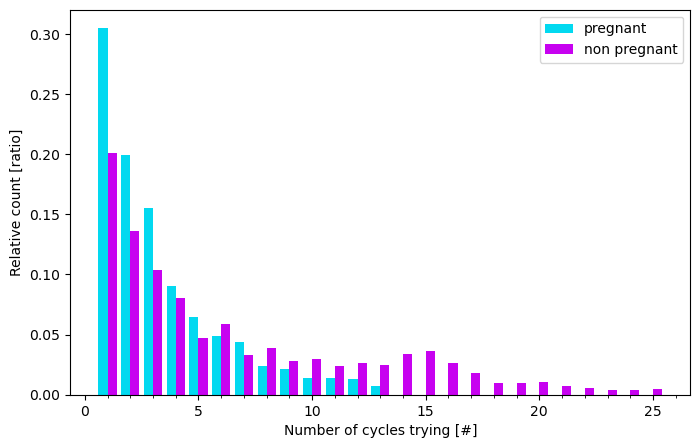

In [96]:
# Histogram to visualize the distribution of "pregnant" VS "non-pregnant" couples

pregnant_ntries = ncdata[ncdata['outcome'] == 'pregnant']['n_cycles_trying']
nonpregnant_ntries = ncdata[ncdata['outcome'] == 'not_pregnant']['n_cycles_trying']

fig = plt.figure(figsize=[8, 5])
ax = fig.add_subplot(111)
plt.hist([pregnant_ntries, nonpregnant_ntries], bins=25, label=('pregnant', 'non pregnant'), density=True, align='left', color=('#02D9F0', '#C702F0'))
ax.legend()
ax.xaxis.set_minor_locator(MultipleLocator(1))  # Increase the number of minor ticks to facilitate the count
ax.set_xlabel('Number of cycles trying [#]')
ax.set_ylabel('Relative count [ratio]')

plt.show()

## What factors impact the time it takes to get pregnant?


In [64]:
#ncdata.query('outcome == "pregnant"', inplace = True)

#This is the variable representing the time it gets to get pregnant
#ncdata['conceiving_time_trying_days'] = ncdata['n_cycles_trying'] * ncdata['average_cycle_length']
#ncdata.dropna(subset=['conceiving_time_trying_days'], inplace = True)

### Correlation analysis

Here I perform some exploratory data analysis and compute correlation between n_cycles_trying and all other variables. <br>

- I compute Spearman correlation index between n_cycles_trying and all continuos variables (such as bmi)
- I compute Point Biserial correlation index between n_cycles_trying and all binary categorical variables (such as regular_cycle).
- I compute the Spearman rank correlation index between n_cycles_trying and all ordinal variables (categorical variables that have natural ordered categories, such as been_pregnant_before, which can be re-coded to numerical values).
- For what concerns correlation between n_cycles_trying and non-ordinal categorical variables with more than two classes, such as country and sleeping_patterns, there are few options but none of them are completely satisfactory:
    - One-sided ANOVA cannot be used because it assumes that variables are distributed normally
    - Point Biserial correlation cannot be used because it only deals with binary categorical variables. <br> A possible solution, yet not ideal, could be to create a series of dummy variables for the categorical variable and calculate the point-biserial correlation between conceiving_time_trying_days and the dummy variables.

Some comments:
- I use Spearman correlation index instead of Pearson because the latter assumes that variables are distributed normally and it only tests linear relationship between variables.
- I make the assumption that the variable education has a natural ordering, that it to say 'Elementary school' < 'High school' < 'Trade/technical/vocational training' < 'University' < 'PhD'.

In [65]:
ncdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1995 entries, 0 to 1994
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bmi                    1995 non-null   float64
 1   age                    1995 non-null   int64  
 2   country                1882 non-null   object 
 3   been_pregnant_before   1678 non-null   object 
 4   education              1604 non-null   object 
 5   sleeping_pattern       1496 non-null   object 
 6   n_cycles_trying        1995 non-null   int64  
 7   outcome                1995 non-null   object 
 8   dedication             1995 non-null   float64
 9   average_cycle_length   1989 non-null   float64
 10  cycle_length_std       1970 non-null   float64
 11  regular_cycle          1989 non-null   object 
 12  intercourse_frequency  1995 non-null   float64
dtypes: float64(5), int64(2), object(6)
memory usage: 202.7+ KB


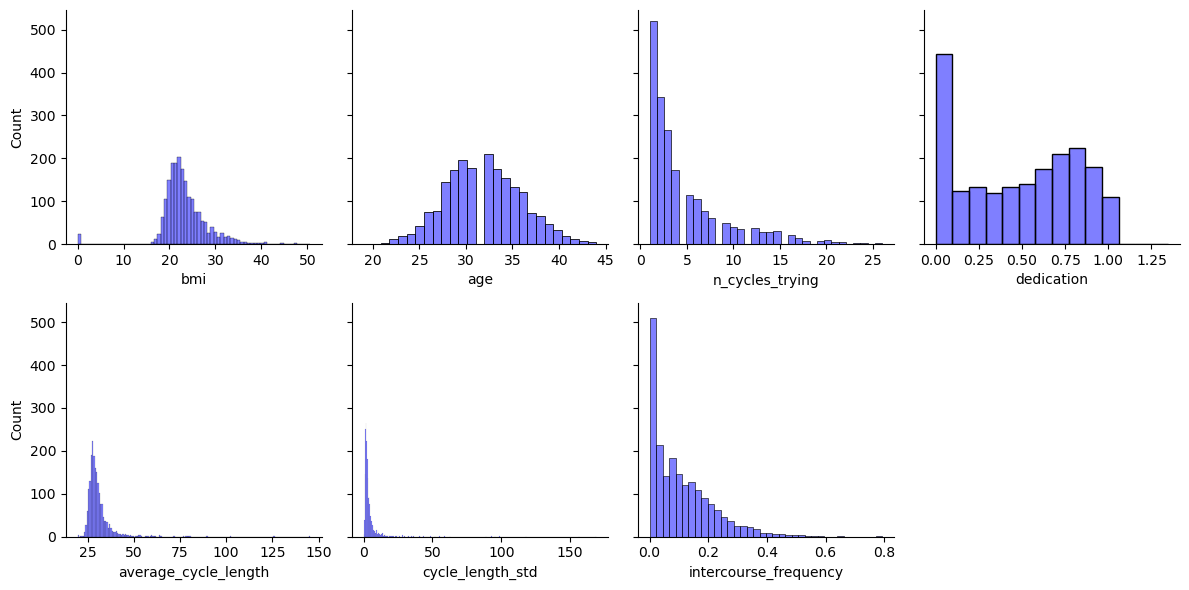

In [66]:
ncdata_contin = ncdata.select_dtypes("number").copy()#.dropna().copy()

g = sns.FacetGrid(pd.DataFrame(ncdata_contin.columns), col=0, col_wrap=4, sharex=False)
for ax, x_var in zip(g.axes, ncdata_contin.columns):
    sns.histplot(data=ncdata_contin, x=x_var, ax=ax, alpha=0.5, color='b')
g.tight_layout()

plt.show()

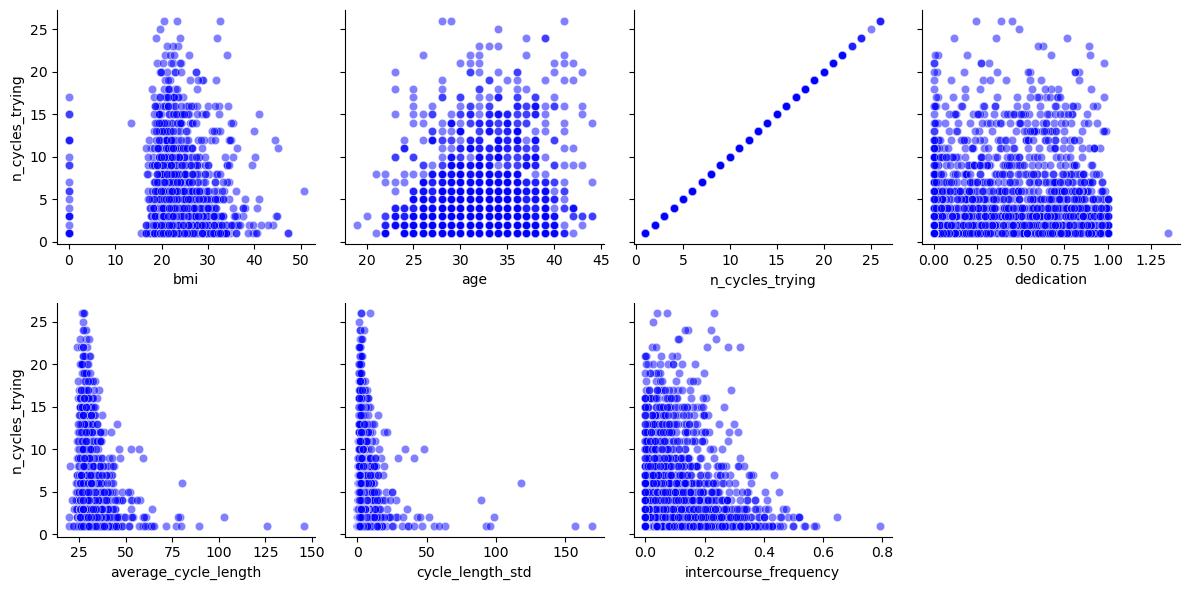

In [67]:
g = sns.FacetGrid(pd.DataFrame(ncdata_contin.columns), col=0, col_wrap=4, sharex=False)
for ax, x_var in zip(g.axes, ncdata_contin.columns):
    sns.scatterplot(data=ncdata_contin, x=x_var, y='n_cycles_trying', ax=ax, alpha=0.5, color='b')
g.tight_layout()

plt.show()

You can notice some zero values with bmi, which are not realistic. Therefore I will remove them. <br>
Similarly, any value of dedication above one does not make sense, therefore they will be replaced with one. <br>

In [68]:
#ncdata.drop(ncdata[ncdata.bmi == 0.0].index, inplace=True)
ncdata.loc[ncdata['bmi'] == 0.0, 'bmi'] = np.nan
ncdata.loc[ncdata['dedication'] > 1.0, 'dedication'] = 1.0
#ncdata.drop(['n_cycles_trying', 'average_cycle_length', 'cycle_length_std'], axis = 1, inplace=True)

Here I compute the Spearman correlation between all numerical variables. <br>

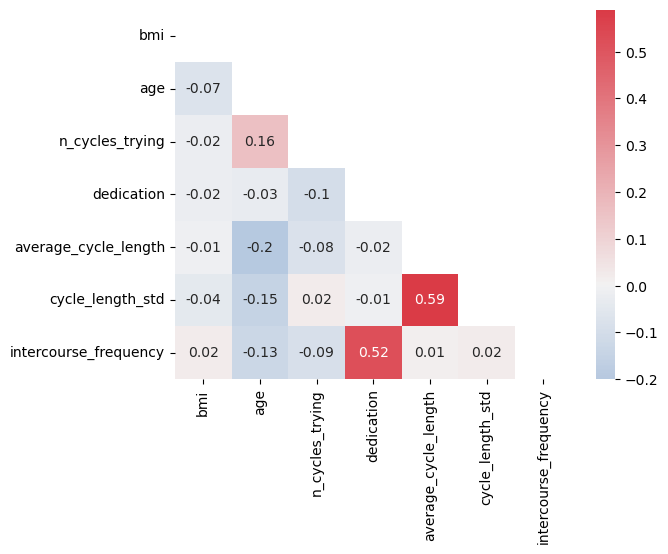

In [69]:
spearman_corr = ncdata.corr('spearman')
spearman_corr = np.round(spearman_corr, 2)

sns.heatmap(spearman_corr, 
            mask = np.triu(np.ones_like(spearman_corr, dtype=bool)),
            xticklabels=spearman_corr.columns.values,
            yticklabels=spearman_corr.columns.values,
            cmap = sns.diverging_palette(250, 10, as_cmap=True), center = 0.0, annot = True)

plt.show()

I assume the following degree of correlation:
- High correlation: value between ± 0.50 and ± 1
- Moderate correlation: value between ± 0.30 and ± 0.49
- Low correlation: value between +0.05 and ±.29
- Nearly no correlation: value between 0.00 and ±.05

The correlation analysis shows the following:
- low positive correlation between n_cycles_trying and age,
- nearly no correlation between n_cycles_trying and bmi (-0.02) and cycle_length_std (0.02).
- low negative correlation between n_cycles_trying and dedication (-0.1), average_cycle_length (-0.2), intercourse_frequency (-0.09). Notice that dedication and intercourse_frequency are also positively correlated to each other.

Now I compute the Point Biserial correlation between n_cycles_trying and the binary categorical variables. <br>
In this case the variable is regular_cycle. <br>
In addition, I will also perform a one-sided Mann-Whitney U test. This will test wheter the distribution underlying variable n_cycles_trying when the categorical variable has value 'True' is stochastically less/greater than the same distribution when the categorical variable has value 'False'.

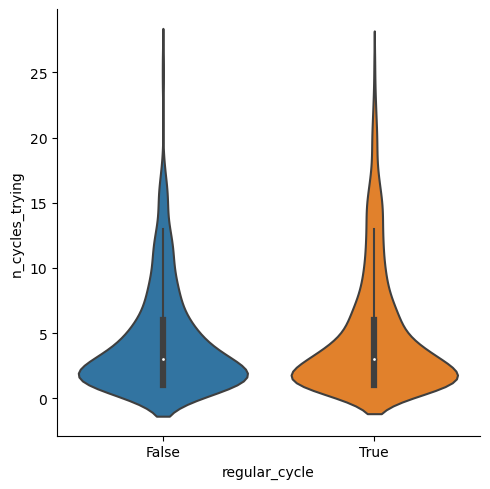

In [71]:
sns.catplot(x="regular_cycle", y="n_cycles_trying",
            data=ncdata, kind="violin")

plt.show()

In [76]:
ncdata_bis = ncdata[['regular_cycle', 'n_cycles_trying']].dropna()
(corr, pvalue) = stats.pointbiserialr(ncdata_bis['regular_cycle'], ncdata_bis['n_cycles_trying']) ## for binary - numerical correlation
(corr, pvalue) = (np.round(corr, 2), np.round(pvalue, 6))
print("Point biserial correlation between regular_cycle and n_cycles_trying: " + str(corr) + ", p-value: " + str(pvalue))

print("Mann-Whitney U test:")
print("check if the distribution of n_cycles_trying for women who have a regular cycle is stochastically less than for women with irregular cycle")
regular_cycle_cttd = ncdata_bis[ncdata_bis['regular_cycle'] == True]['n_cycles_trying']
not_regular_cycle_cttd = ncdata_bis[ncdata_bis['regular_cycle'] == False]['n_cycles_trying']
stats.mannwhitneyu(regular_cycle_cttd, not_regular_cycle_cttd,  nan_policy = 'omit', alternative="less")


Point biserial correlation between regular_cycle and n_cycles_trying: 0.05, p-value: 0.028626
Mann-Whitney U test:
check if the distribution of n_cycles_trying for women who have a regular cycle is stochastically less than for women with irregular cycle


MannwhitneyuResult(statistic=341217.5, pvalue=0.8721827988275028)

The data shows low negative correlation between n_cycles_trying and regular_cycle <br>
The Mann-Whitney U test, given the p-value > 0.05, shows that given the two distributions of n_cycles_trying, for women with regular cycle and with no regular cycle, we can't say that they are significantly different and that the former is stochastically less than the latter. <br>

Now I compute the Spearman rank correlation index between conceiving_time_trying_days and the ordinal categorical variables.<br>
In this case the variables are been_pregnant_before and education. It is also necessary to re-code these variables to numerical values.

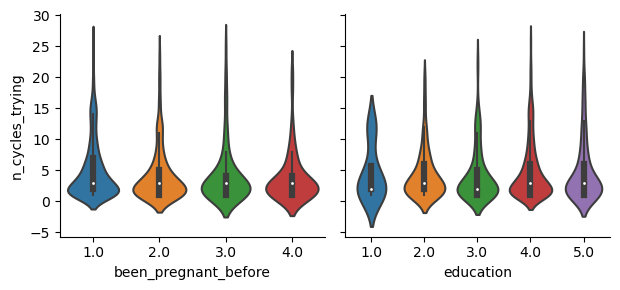

In [78]:
ncdata_ordinal = ncdata[['been_pregnant_before', 'education', 'n_cycles_trying']].copy()

coding = {'No, never': 1, 'Yes, once': 2, 'Yes, twice': 3, 'Yes 3 times or more': 4}
ncdata_ordinal['been_pregnant_before'] =  ncdata_ordinal['been_pregnant_before'].replace(coding)

coding = {'Elementary school': 1, 'High school': 2, 'Trade/technical/vocational training': 3, 'University': 4, 'PhD': 5}
ncdata_ordinal['education'] =  ncdata_ordinal['education'].replace(coding)

g = sns.FacetGrid(pd.DataFrame(ncdata_ordinal.columns[:-1]), col=0, col_wrap=4, sharex=False)
for ax, x_var in zip(g.axes, ncdata_ordinal.columns[:-1]):
    sns.violinplot(data=ncdata_ordinal, x=x_var, y='n_cycles_trying', ax=ax)
g.tight_layout()

plt.show()
    

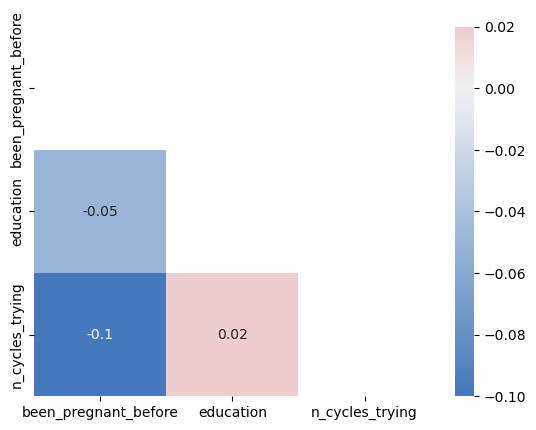

In [79]:
spearman_corr = ncdata_ordinal.corr(method='spearman')
spearman_corr = np.round(spearman_corr, 2)


sns.heatmap(spearman_corr, 
            mask = np.triu(np.ones_like(spearman_corr, dtype=bool)),
            xticklabels=spearman_corr.columns.values,
            yticklabels=spearman_corr.columns.values,
            cmap = sns.diverging_palette(250, 10, as_cmap=True), center = 0.0, annot = True)

plt.show()

The correlation analysis shows the following:
- nearly no correlation between n_cycles_trying and education (0.02).
- low negative correlation between n_cycles_trying and been_pregnant_before (-0.1).

Finally, the non-ordinal categorical variables are country and sleeping_pattern.

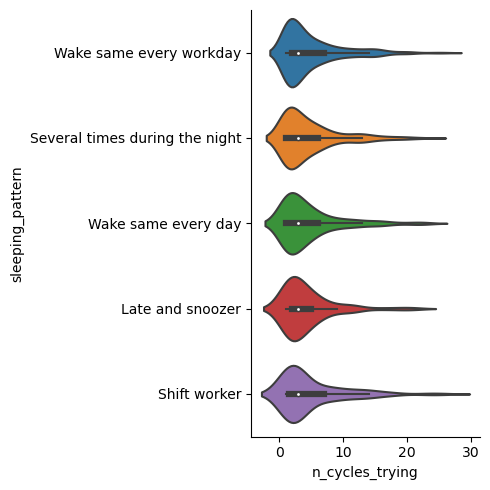

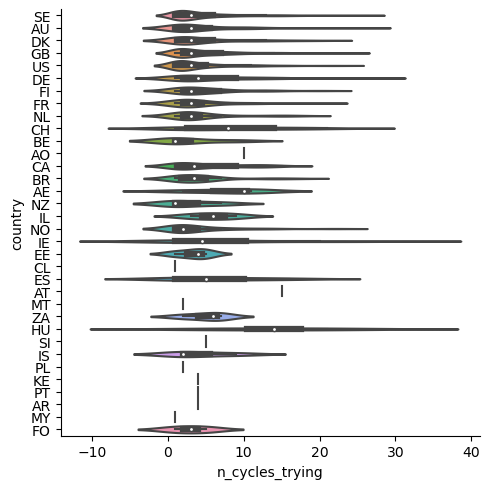

In [80]:
sns.catplot(y="sleeping_pattern", x="n_cycles_trying",
            data=ncdata, kind="violin")

sns.catplot(y="country", x="n_cycles_trying",
            data=ncdata, kind="violin")

plt.show()

### Unsing ML to predict the time it takes to get pregnant.

Another way to identify the factors that impact the time to get pregnant is to use a ML model to predict n_cycles_trying. In particular, models that are based on trees ensemble, such as the Light Gradient Boosting Machine, allow to rank input variables according to importance.

In [82]:
#!pip install lightgbm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

ncdata_lgb = pd.read_csv('NCDataChallenge_2021_v1_-_NCDataChallenge_2021_v1.csv') 
ncdata_lgb.drop(['Unnamed: 0'], axis = 1, inplace=True)
#ncdata_lgb.query('outcome == "pregnant"', inplace=True)
ncdata_lgb.dropna(subset=['n_cycles_trying'], inplace=True)

obj_feat = list(ncdata_lgb.loc[:, ncdata_lgb.dtypes == 'object'].columns.values)
for feature in obj_feat:
    ncdata_lgb[feature] = pd.Series(ncdata_lgb[feature], dtype="category")

cols = ncdata_lgb.select_dtypes([np.number]).columns
ncdata_lgb[cols] = preprocessing.scale(ncdata_lgb[cols])


x_train,x_test,y_train,y_test = train_test_split(ncdata_lgb.drop(['n_cycles_trying'], axis = 1), 
                                                 ncdata_lgb['n_cycles_trying'], 
                                                 test_size=0.2, random_state=42)

C:\Users\AntonioFisk\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\AntonioFisk\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[833]	training's l2: 0.685483	valid_0's l2: 0.680515


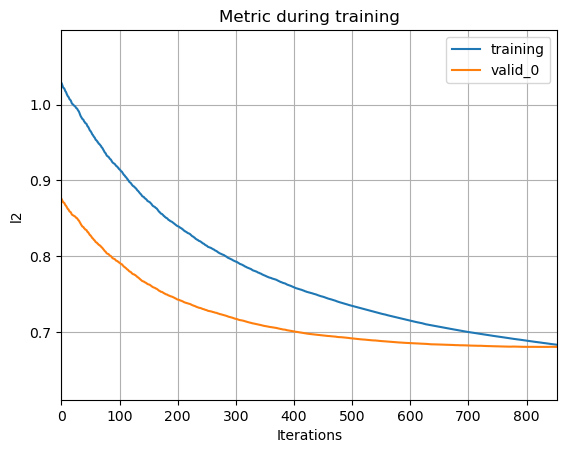

In [83]:
params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'mse',
    'colsample_bytree': 0.5,
    'learning_rate': 0.005,
    'max_depth': -1,
    'n_estimators': 3000,
    'num_leaves': 4,
    'subsample': 0.4
}

model = lgb.LGBMRegressor(**params)

model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)], 
          callbacks = [lgb.log_evaluation(period=0), lgb.early_stopping(20)])

lgb.plot_metric(model)
plt.show()

Some hyperparameter optimization would be needed in order to improve the performance, but it is out of the scope of the assignment.

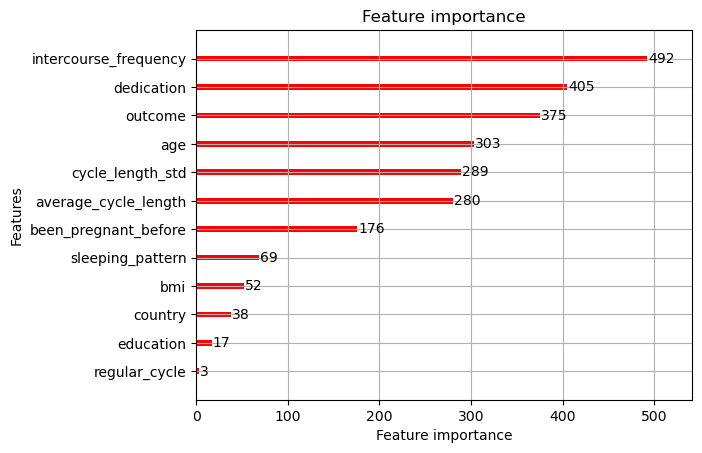

In [84]:
lgb.plot_importance(model, color='red', importance_type = 'split', max_num_features = 20)
plt.show()

In the plot above you can see the input variables ranked according to importance. The variables at the top ranks are the best predictors for the time required to get pregnant.